# Procesamiento de datos y creación de features


En este cuaderno de Jupyter se crean las 20 features necesarias para el entrenamiento de nuestros modelos de aprendizaje. 

- Primero se cargan los datasets descargados de Yahoo Finance y que se encuentran guardados en la carpeta "datasets". 

- Después, para cada uno de los datasets se construyen los 20 features y se añaden como columnas extra a los dataframes originales. Estos nuevos datasets se almacenan en un diccionario global, cuyas claves son los nombres/etiquetas de cada una de las acciones. 

- Finalmente los nuevos datasets (que contienen los 20 features + datos otiginales) se guardan en una carpeta externa llamada "datasets_features". A esta carpeta accederemos desde otros jupyter notebooks para entrenar los modelos.  

Se añade, como complemento, unas líneas de código para visualizar los features de una de las acciones en concreto. 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os 

# indicadores 
import ta
from ta.momentum import RSIIndicator, ROCIndicator 
from ta.trend import PSARIndicator
from ta.volatility import AverageTrueRange

In [2]:
# Nombre de las acciones
tickers = [
    'TSCO', 'AZN', 'BARC', 'BP', 'BATS', 'HLMA',
    'HSBA', 'JMAT', 'LGEN', 'MKS', 'PSON', 'REL',
    'NWG', 'SHEL', 'SGE', 'SBRY', 'SDR', 'SVT',
    'SMIN', 'SSE', 'VOD'
]

Guardaré los features en un diccionario de dataframes. 

In [23]:

# Inicializo diciconario de data frames
data_frames = {}

# Bucle de lectura de datasets
for ticker in tickers: 
    #Leo el dataset
    df = pd.read_csv(f'datasets/{ticker}.L_1994_2019_adjusted.csv')
    
    
    # ---------- Construyo los features de cada data frame --------------------
    #Lags 
    df['r1'] = np.log(df['Close'])          - np.log(df['Close'].shift(1))   
    df['r2'] = np.log(df['Close'].shift(1)) - np.log(df['Close'].shift(2)) 
    df['r3'] = np.log(df['Close'].shift(2)) - np.log(df['Close'].shift(3)) 
    df['r4'] = np.log(df['Close'].shift(3)) - np.log(df['Close'].shift(4)) 

    df['r5'] = np.log(df['High']) - np.log(df['Open']) 
    df['r6'] = np.log(df['High']) - np.log(df['Open'].shift(1)) 
    df['r7'] = np.log(df['High']) - np.log(df['Open'].shift(2)) 
    df['r8'] = np.log(df['High']) - np.log(df['Open'].shift(3)) 

    df['r9'] = np.log(df['High'].shift(1)) - np.log(df['Open'].shift(1)) 
    df['r10'] = np.log(df['High'].shift(2)) - np.log(df['Open'].shift(2)) 
    df['r11'] = np.log(df['High'].shift(3)) - np.log(df['Open'].shift(3)) 

    df['r12'] = np.log(df['Low']) - np.log(df['Open']) 
    df['r13'] = np.log(df['Low'].shift(1)) - np.log(df['Open'].shift(1)) 
    df['r14'] = np.log(df['Low'].shift(2)) - np.log(df['Open'].shift(2)) 
    df['r15'] = np.log(df['Low'].shift(3)) - np.log(df['Open'].shift(3)) 

    # Relative Strength Index (RSI)
    rsi_indicator = RSIIndicator(close=df['Close'], window=14)
    df['RSI_14'] = rsi_indicator.rsi()

    # Momentum Index
    momentum = ROCIndicator(close=df['Close'], window=10)
    df['Momentum_10'] = momentum.roc()

    #True range
    df['prev_close'] = df['Close'].shift(1)
    tr1 = df['High'] - df['Low']
    tr2 = (df['High'] - df['prev_close']).abs()
    tr3 = (df['Low'] - df['prev_close']).abs()
    df['True_Range'] = np.maximum.reduce([tr1, tr2, tr3])

    # Average True Range
    atr_indicator = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['ATR_14'] = atr_indicator.average_true_range()

    # SAR indicator 
    psar_indicator = PSARIndicator(high=df['High'], low=df['Low'], close=df['Close'],
                                    step=0.02, max_step=0.2) # max_step=0.0??
    df['PSAR'] = psar_indicator.psar()

    
    
    # ---------- Construyo los targets de cada data frame --------------------
    df['target'] = np.log(df['Close'].shift(-1)) - np.log(df['Close'])
    
    
    # ---------- Almaceno los data frames en un diccionario --------------------
    
    # Elimino nan 
    df_final = df.dropna()
    
    # guardo dataframes
    data_frames[ticker] = df_final
    

In [116]:

# Guardaré estos dataframes en una carpeta externa para luego acceder a los features 

carpeta = os.path.join(os.getcwd(), 'datasets_features')

# creo la nueva carpeta (si no existe)
os.makedirs(carpeta, exist_ok=True)

# recorro el dicccionario de dataframes y los voy guardando
for nombre, df in data_frames.items():
    ruta = os.path.join(carpeta, f"{nombre}.csv")
    df.to_csv(ruta, index=False) # no guarda el índice


## Visualización de features 

In [121]:
# selecciono un dataset 
df = data_frames['AZN']

# Tengo 15 features lag, y 5 features que son indices financieros
n_lag = 15
n_indices = 5

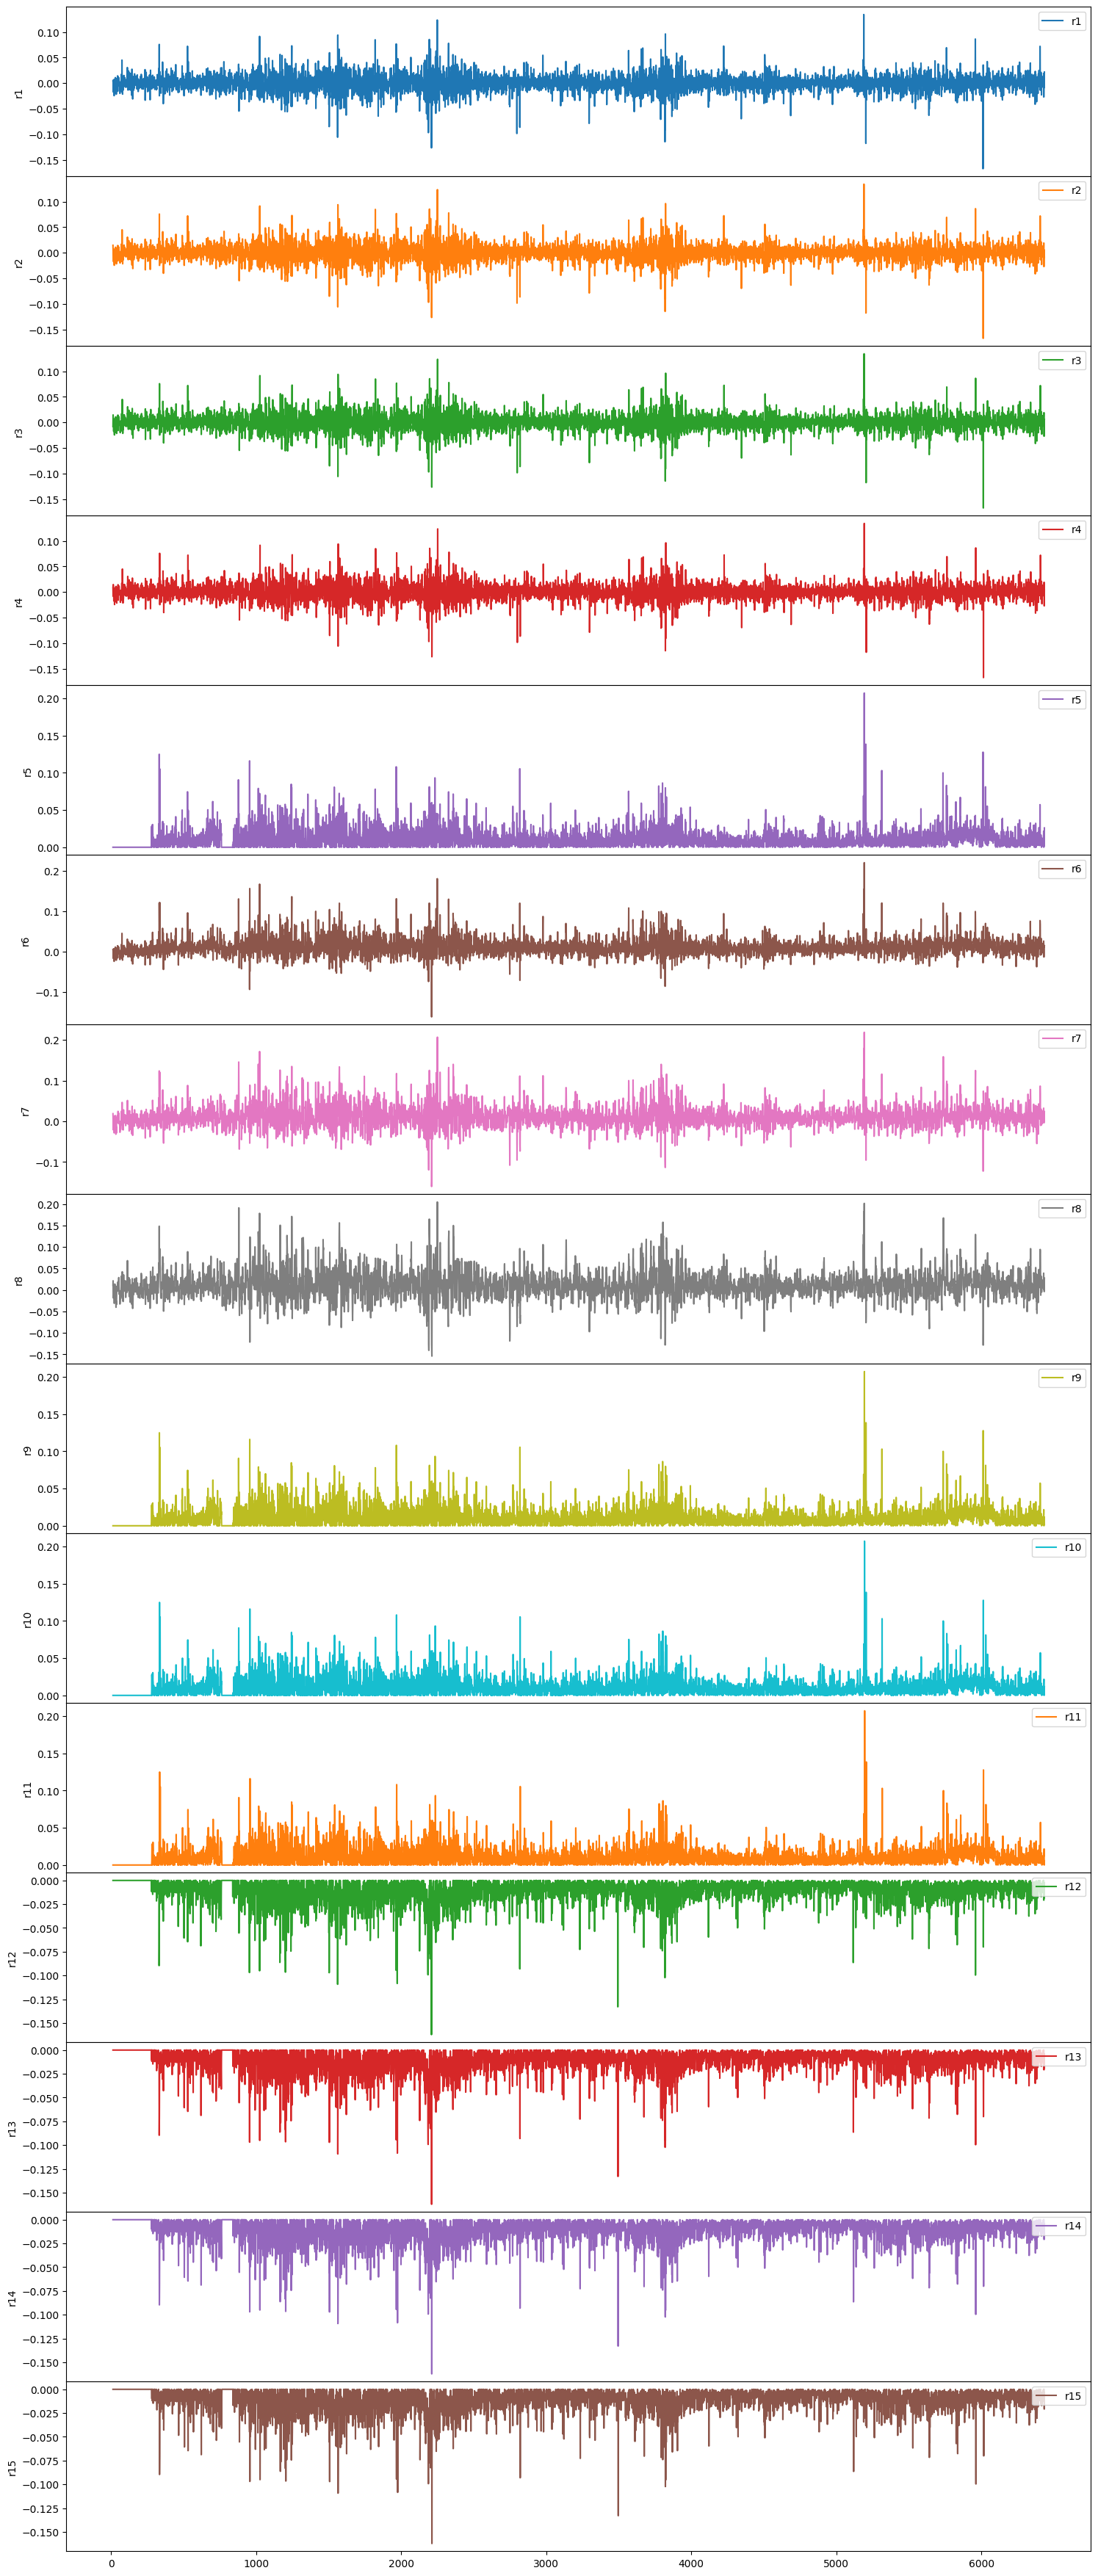

In [128]:
# Grafico los  15 features lag 

features_names = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8',
                  'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15']
colores = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 
          'C6', 'C7', 'C8', 'C9', 'C1', 'C2', 
          'C3', 'C4', 'C5', 'C6', 'C7', 'C8']


fig, axes = plt.subplots(n_lag, 1, figsize=(18, 3 * 15), sharex=True )

for i in range(n_lag): 
    feature = features_names[i]
    ax = axes[i]
    color = colores[i]
    
    # grafico
    ax.plot(df[feature], color = color, label = f'{feature}')
    ax.set_ylabel(feature, fontsize=10)
    ax.legend(loc='upper right', fontsize=10)

plt.subplots_adjust(hspace=0)
plt.show()

# Guardo imagen en png
ruta_archivo = 'imagenes/features_lags.png'
fig.savefig(ruta_archivo, dpi=300, bbox_inches='tight')


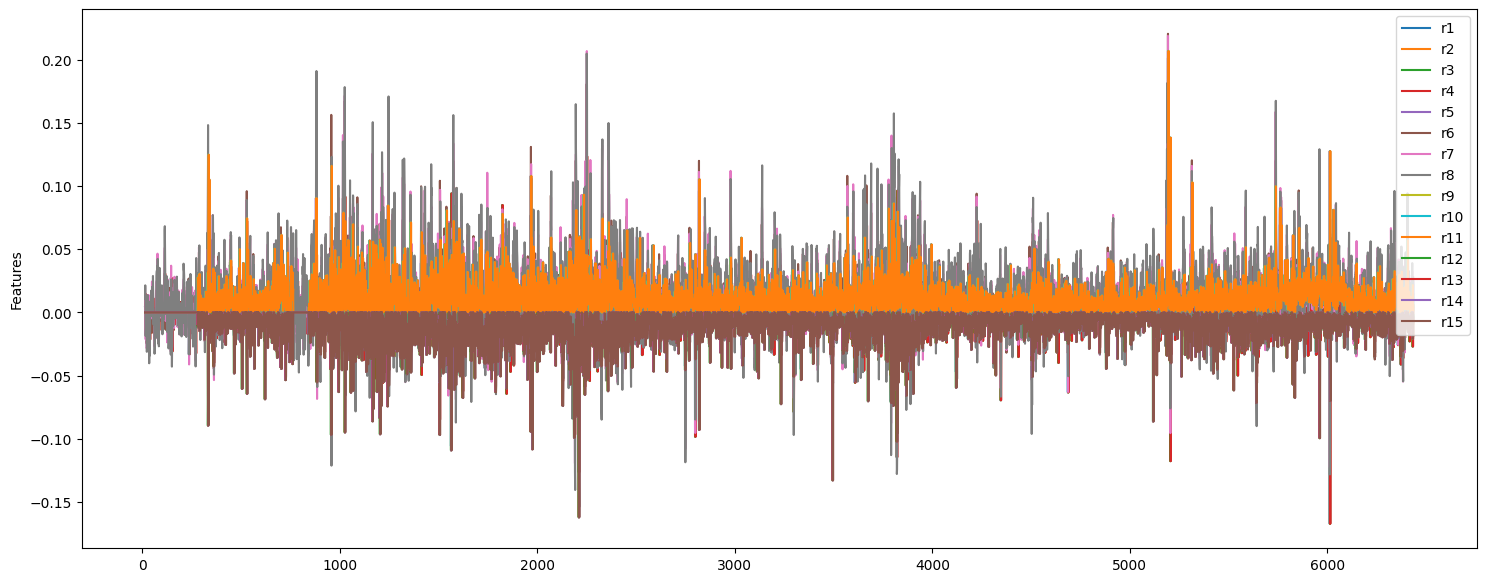

In [130]:
# Los dibujo todas en la misma gráfica 

features_names = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8',
                  'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15']
colores = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 
          'C6', 'C7', 'C8', 'C9', 'C1', 'C2', 
          'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

fig, ax = plt.subplots(figsize=(18, 7), sharex=True )

for i in range(n_lag): 
    feature = features_names[i]
    color = colores[i]
    
    # grafico
    ax.plot(df[feature], color = color, label = f'{feature}')
    ax.set_ylabel('Features', fontsize=10)
    ax.legend(loc='upper right', fontsize=10)


plt.subplots_adjust(hspace=0)
plt.show()

# Guardo imagen en png
ruta_archivo = 'imagenes/features_lags2.png'
fig.savefig(ruta_archivo, dpi=300, bbox_inches='tight')


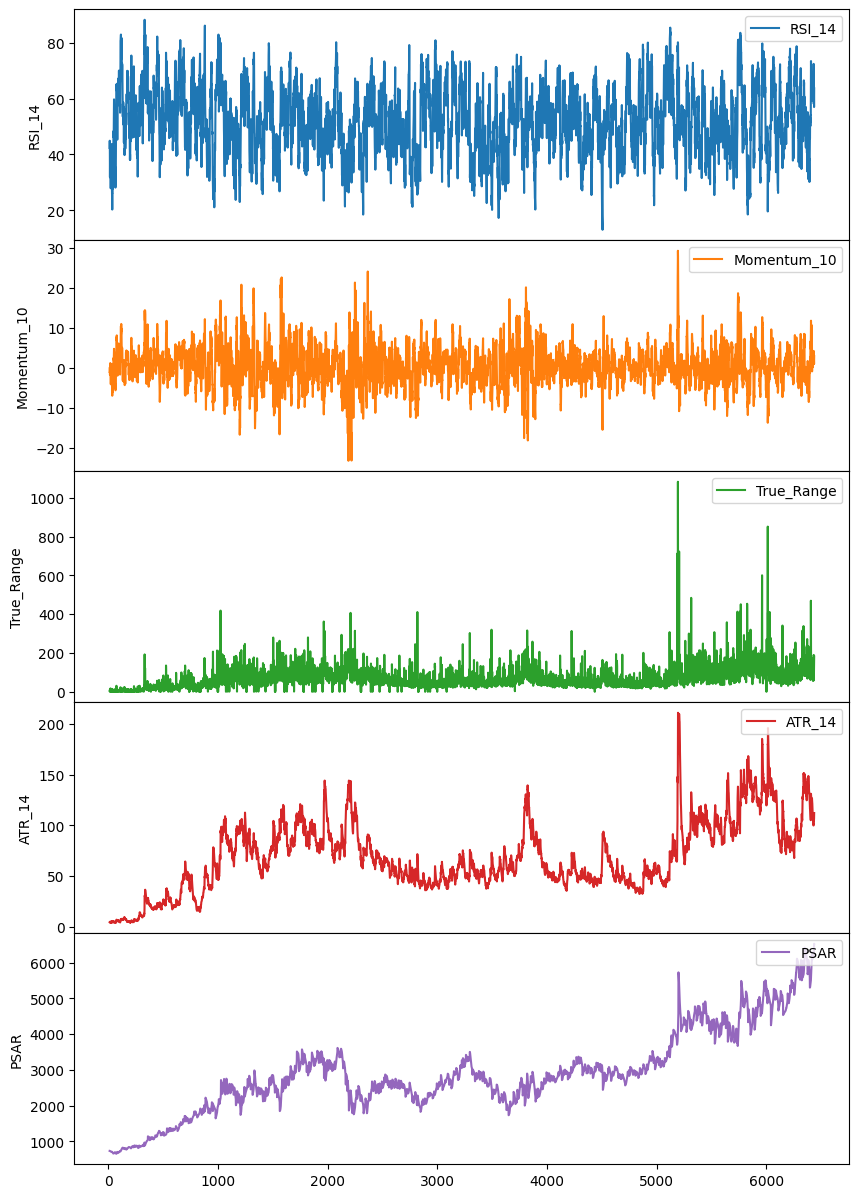

In [124]:
# Grafico los 5 features que son indicadores financieros  

features_names = ['RSI_14', 'Momentum_10', 'True_Range', 'ATR_14', 'PSAR']
colores = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

fig, axes = plt.subplots(n_indices, 1, figsize=(10, 3 * n_indices), sharex=True )

for i in range(n_indices): 
    feature = features_names[i]
    ax = axes[i]
    color = colores[i]
    
    # grafico
    ax.plot(df[feature], color = color, label = f'{feature}')
    ax.set_ylabel(feature, fontsize=10)
    ax.legend(loc='upper right', fontsize=10)

plt.subplots_adjust(hspace=0)
plt.show()

# Guardo imagen en png
ruta_archivo = 'imagenes/features_indices.png'
fig.savefig(ruta_archivo, dpi=300, bbox_inches='tight')